# Laboratorium 8 - SVD - wyszukiwarka

In [1]:
import os
import numpy as np
from nltk.tokenize import word_tokenize as tokenizer
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")
from string import punctuation
from scipy.sparse.linalg import svds as svd
from scipy.sparse import lil_matrix

Na początek opiszę jedną z większych trudności projektu. Z racji dużej liczby artykułów potrzeba dużej pamięci RAM. W moim laptopie znajduje się 16GB tejże pamięci. Wykonując projekt często zdarzało mi się wykorzystywać pamięć ze SWAPu. Po testach udało się zmieścić w RAMie redukując słownik do 60 tysięcy słów oraz wykorzystując typ `np.float32` do reprezentowania danych w macierzy po wymnożeniu SVD.

## Wczytanie dokumentów

Funkcja wczytuje plik tekstowy 'corpus.txt, w którym zawarte są artykuły pochodzące z angielskiej wikipedii. Artykułów jest 50441. Są one rozdzielane do plików, po jednym pliku na artykuł i przechowywane w folderze 'sites'. Krok ten został wykonany w celu ułatwienia korzystania i otwierania konkretnych artykułów. Plik z artykułami pochodzi ze strony: https://github.com/LGDoor/Dump-of-Simple-English-Wiki.

In [2]:
def read_wikipedia (filepath = "corpus.txt", directory = "sites"):
    if not os.path.exists(directory):
        os.mkdir(directory)
    f = open (filepath, 'r')
    text = f.read()
    f.close()
    text = text.split("\n\n")
    for i, site in enumerate(text):
        fp = directory + "/" + "site" + str(i) + ".txt"
        f = open (fp, 'w')
        f.write(site)
        f.close()

## Utworzenie słownika

Na początek przyjąłem słownik jako zbiór wszystkich słów występujących we wszystkich artykułach z wyłączeniem słów ze stop listy i słów zawierających znaki interpunkcyjne. Jako stop listę przyjąłem zbiór pochodzący z biblioteki `nltk` (gotowa stop lista dla języka angielskiego). Kolejnym ważnym aspektem jest wykorzystanie tokenizera z tej samej biblioteki, który wykorzystuje do wyodrębnienia słów w tekście. Tutaj jak i za każdym razem w projekcie korzystam z tekstu po zamianie wielkich liter na małe. Słownik zbudowany ze wszystkich słów dobrze sprawdzał się dopóki korzystam z macierzy rzadkich. Po policzeniu SVD i redukcji szumu macierz jest zbyt duża i nie mieści się w RAMie. Z tego powodu zdecydowałem zmniejszyć słownik do 60000 słów. Rozpocząłem poprzez wybieranie 60 tysięcy słów najmniej, najbardziej licznych lub ze środka. Jednakże z powodu wielu bardzo krótkich artykułów metoda ta się nie sprawdzała. Ostatecznie słownik buduję ze słów pochodzących z tytułów artykułów, daje to nieco ponad 38 tysięcy. Dzięki temu zabiegowi każdy artykuł ma swojego reprezentanta w słowniku. Słownik dopełniam do 60 tysięcy najliczniejszymi z pozostałych słów. Robię to z faktu wykorzystania stoplisty więc pozbyłem się słów nie niosących znaczenia i potrzeby rozbudowania wektorów z artykułów. Słownik zapisuję do pliku 'dict.txt', aby móc z niego korzystać wielokrotnie i w aplikacji. Ostatnią poprawą było wykorzystanie funkcji sprowadzającej słowo do rdzenia - `nltk.stem.snowball.SnowballStemmer` dla języka angielskiego. Korzystam z niej przy tworzeniu słownika oraz przy tworzeniu wektora `bag_of_words`. Ta poprawka zwiększa znacząco wartość słów w słowniku oraz możliwości wyszukiwarki.

In [3]:
def make_dictionary (stop_words, directory = "sites"):
    #size = 60000
    l = list(os.listdir(directory))
    counter = {}
    for file in l:
        filepath = directory + "/" + file
        f = open (filepath, 'r')
        text = f.read().lower()
        f.close()
        words = tokenizer(text)
        for word in words:
            if any([l in punctuation for l in word]):
                continue
            word = stemmer.stem(word)
            if word in stop_words:
                continue
            
            counter[word] = counter.get(word, 0) + 1
    arr = list (counter.items())
    #arr.sort(reverse=True, key=lambda x : x[1])
    #arr = arr[:size]
    #arr = arr[(-1)*size:]
    #k = (len(arr)-size)//2
    #arr = arr[k:k+size]
    dictionary = {}
    for i, k in enumerate(arr):
        word = k[0]
        dictionary[word] = i
    return dictionary

In [4]:
def dictionary_from_titles (stop_words, directory = "sites"):
    size = 60000
    l = list(os.listdir(directory))
    counter = {}
    for file in l:
        filepath = directory + "/" + file
        f = open (filepath, 'r')
        text = f.read().lower()
        f.close()
        text = text.split('\n')[0]
        words = tokenizer(text)
        for word in words:
            if any([l in punctuation for l in word]):
                continue
            word = stemmer.stem(word)
            if word in stop_words:
                continue
            counter[word] = counter.get(word, 0) + 1
    arr = list (counter.items())
    size -= len (arr)
    
    counter2 = {}
    for file in l:
        filepath = directory + "/" + file
        f = open (filepath, 'r')
        text = f.read().lower()
        f.close()
        words = tokenizer(text)
        for word in words:
            if any([l in punctuation for l in word]):
                continue
            word = stemmer.stem(word)
            if word in stop_words:
                continue
            if word in counter:
                continue
            counter2[word] = counter2.get(word, 0) + 1
    arr2 = list (counter2.items())
    
    arr2.sort(reverse=True, key=lambda x : x[1])
    #arr2 = arr2[:size]
    arr2 = arr2[(-1)*size:]
    #k = (len(arr2)-size)//2
    #arr2 = arr2[k:k+size]
    
    arr.extend(arr2)
    
    dictionary = {}
    for i, k in enumerate(arr):
        word = k[0]
        dictionary[word] = i
    return dictionary

In [5]:
def save_dictionary (dictionary, filepath='dict.txt'):
    f = open (filepath, 'w')
    f.write (str(dictionary))
    f.close()

## Obliczenie wektora z artykułu

Każdy artykuł reprezentuje jako wektor `bag_of_word`. Jest to wektor zawierający liczność kolejnych słów ze słownika w danym artykule. Z racji, że wektory te są rzadkie przechowuje je jako słownik. Funkcja `normalise` ma za zadanie unormować wektor, aby jego długość wynosiła 1. Funkcja `normalise_vectors` normuje listę wektorów. Funkcja `IDF_func` przekształca wektory poprzez przemnożenie ich przez współczynnik IDF. IDF dla danego słowa ze słownika to logarytm z ilorazu liczby dokumentów z liczbą dokumentów z danym słowem. Celem tej operacji jest redukcja znaczenia często występujących słów.

In [6]:
def make_bag_of_word (dictionary, text, normal=False):
    words = tokenizer(text)
    vector = {}
    for word in words:
        word = stemmer.stem(word)
        idx = dictionary.get(word, -1)
        if idx == -1:
            continue
        vector[idx] = vector.get(idx, 0) + 1
    if normal:
        vector = normalise(vector)
    return vector

In [7]:
def normalise (vector):
    s = 0
    for v in vector.values():
        s += v**2
    s = np.sqrt(s)
    if s == 0:
        return vector
    for key in vector.keys():
        t = vector[key]
        vector[key] = t / s
    return vector

In [8]:
def normalise_vectors (vectors):
    for i in range (len (vectors)):
        vectors[i] = normalise(vectors[i])
    return vectors

In [9]:
def IDF_func (vectors, n):
    new_vec = []
    N = len (vectors)
    IDF = np.zeros(n)
    for vector in vectors:
        new_vec.append(vector.copy())
        for key in vector.keys():
            IDF[key] += 1
    IDF = np.log(N / IDF)
    for i in range (N):
        for key in new_vec[i].keys():
            new_vec[i][key] *= IDF [key]
    return new_vec

## Redukcja szumu

Funkcja wykorzystująca SVD do redukcji szumu. Polega na policzeniu SVD z k wartościami własnymi. Dzięki temu po wymnożeniu uzyskujemy przybliżenie macierzy wejściowej ze zredukowanym szumem. Pozwala to na wyszukiwanie artykułów na podstawie słów związanych znaczeniowo z artykułem, a nie bezpośrednio w nich występujących. Ważną cechą jest zastosowanie liczb zmiennoprzecinkowych pojedynczej precyzji co znacząco poprawia wydajność (celem zmieszczenie się w RAMie).

In [10]:
def reduce_noise (vectors, k, size):
    l = len (vectors)
    matrix = lil_matrix((l, size), dtype=np.float64)
    for i, vector in enumerate(vectors):
        for j, val in vector.items():
            matrix[i, j] = val
    u, s, vh = svd(matrix, k=k)
    del (matrix)
    u = u.astype(np.float32)
    s = s.astype(np.float32)
    vh = vh.astype(np.float32)
    new_matrix = u @ np.diag(s) @ vh
    return new_matrix

## Przygotowywanie plików z danymi

Aby umożliwić korzystanie z aplikacji funkcja `prepare_sites_raw` czyta artykuły i dla każdego z nich na podstawie słownika tworzy plik z wektorami `bag_of_words`. Jedna linia w pliku do jeden artykuł w postaci [numer id]\\$[ścieżka do pliku]\\$[wektor]. Jako że tytuł artykułu jest ważny to słowa z niego pochodzące mają wagę 5.

In [11]:
def prepare_sites_raw (dictionary, directory = "sites", filepath = "raw_data.txt"):
    l = list(os.listdir(directory))
    arr = []
    s = open (filepath, 'w')
    for i, file in enumerate(l):
        fp = directory + "/" + file
        f = open (fp, 'r')
        text = f.read().lower()
        f.close()
        title = text.split('\n')[0]
        vector = make_bag_of_word (dictionary, title + (" " + text)*4)
        arr.append(vector)
        line = str(i) + "$" + fp + "$" + str(vector) + "\n"
        s.write (line)
    s.close()

## Odczyt danych

Następujące funkcje przetwarzają wcześniej przygotowane pliki i odczytują słownik słów oraz macierze wektorów. Wykorzystuje je do odczytu danych do testowania. Występują one również w aplikacji `browser.py`.

In [12]:
def read_dictionary (filepath='dict.txt'):
    f = open (filepath, 'r')
    text = f.read()
    f.close()
    text = text[1:][:-1]
    text = text.split(', ')
    dictionary = {}
    for item in text:
        key, val = item.split(': ')
        if "'" in key:
            key = key.split("'")[1]
        dictionary[key] = int(val)
    return dictionary

In [13]:
def read_data (filepath = "data.txt"):
    f = open (filepath, 'r')
    text = f.read()
    f.close()
    text = text.split('\n')
    arr = []
    filepaths = []
    for line in text:
        vector = {}
        if len(line) < 3:
            continue
        string = line.split('$')[2][1:][:-1]
        if len(string) < 3:
            continue
        if ',' in string:
            string = string.split(', ')
        elif ' ' in string and ':' not in string:
            string = string.split()
        else:
            string = [string]
        for i, item in enumerate(string):
            if ':' in item:
                key, val = item.split(': ')
            else:
                key, val = i, item
            vector[int(key)] = float (val)
        filepaths.append (line.split('$')[1])
        arr.append(vector)
    return arr, filepaths

## Wyszukiwanie artykułów

Wyszukiwanie artykułów polega na korzystaniu z wcześniej policzonej listy wektorów. Zapytanie przekształcamy do wektora `bag_of_words` i liczymy odległość cosinusową takiego wektora z każdym z listy i zwracamy k wektorów znajdujących się najbliżej wektora z zapytania. Funkcja `search` przetwarza rezultat do listy tytułów artykułów. W aplikacji `browser.py` korzystamy z analogicznej funkcji `make_search`, jednakże rezultat odpowiednio interpretujemy aby stworzyć odpowiednie GUI.

In [14]:
def cosinus_dis (v, u):
    val_v = 0
    val_u = 0
    for i in v.values():
        val_v += i**2
    for i in u.values():
        val_u += i**2
    val_v = np.sqrt(val_v)
    val_u = np.sqrt(val_u)
    l = 0
    for key, i in v.items():
        l += (i * u.get(key, 0))
    return l / (val_v * val_u)

def cosinus_dis_normal (v, u):
    l = 0
    if isinstance (u, dict):
        for key, i in v.items():
            l += (i * u.get(key, 0))
    else: #jeśli u jest tablicą to znaczy że nie jest unormowany bo pochodzi z wymnożenia macierzy SVD
        for key, i in v.items():
            l += (i * u[key])
        l /= np.sqrt(np.sum(u**2))
    return l

def make_search (question, dictionary, vectors, k, normal=True):
    question = question.lower()
    vector = make_bag_of_word (dictionary, question, normal)
    #for key in vector.keys():
    #    vector[key] = 1
    result = np.zeros((len(vectors), 2))
    result[:,0] = np.arange(len(vectors))
    if normal:
        for i, v in enumerate(vectors):
            result[i, 1] = cosinus_dis_normal (vector, v)
    else:
        for i, v in enumerate(vectors):
            result[i, 1] = cosinus_dis (vector, v)
    result = sorted(result, key=lambda x : x[1], reverse=True)
    return np.array(result)[:k,:]

In [15]:
def search (question, k, dictionary, vectors, filepaths, normal=True):
    result = make_search (question, dictionary, vectors, k, normal)
    for idx, val in result:
        f = open (filepaths[int(idx)], 'r')
        text = f.read()
        f.close()
        title = text.split('\n')[0]
        print (title, "<--", val)

## Przygotowanie danych

Przetworzenie tekstu (utworzenie plików z artykułami).

In [16]:
read_wikipedia ()

Stworzenie słownika zawężonego i zapisanie go do pliku.

In [17]:
swords = stopwords.words('english')
dictionary = dictionary_from_titles (swords)
save_dictionary (dictionary)

Stworzenie pełnego słownika dla testów bez SVD.

In [18]:
dictionary_full = make_dictionary (swords)
save_dictionary (dictionary_full, filepath='dict_full.txt')

Zapisanie wersji surowej wektorów bez przetwarzania. Oraz odczytanie ich do testów.

In [19]:
prepare_sites_raw(dictionary_full, filepath="data_full.txt")
raw_vectors_full, filepaths_full = read_data("data_full.txt")

prepare_sites_raw(dictionary)
raw_vectors, filepaths = read_data("raw_data.txt")

## Testy

Pracuję na wektorach znormalizowanych aby łatwiej obliczać odległość cosinusową. Najpierw sprawdzam wpływ IDF na rezultaty wyszukiwania.

In [20]:
IDF_vectors = IDF_func (raw_vectors, len(dictionary))
IDF_vectors = normalise_vectors (IDF_vectors)
raw_vectors = normalise_vectors (raw_vectors)

In [21]:
IDF_vectors_full = IDF_func (raw_vectors_full, len(dictionary_full))
IDF_vectors_full = normalise_vectors (IDF_vectors_full)
raw_vectors_full = normalise_vectors (raw_vectors_full)

In [22]:
k = 10
question = "animals in Africa"
print ("Search in raw vectors and small dict")
search (question, k, dictionary, raw_vectors, filepaths)
print ()
print ()
print ("Search in IDF vectors and small dict")
search (question, k, dictionary, IDF_vectors, filepaths)
print ()
print ()
print ("Search in raw vectors and full dict")
search (question, k, dictionary_full, raw_vectors_full, filepaths_full)
print ()
print ()
print ("Search in IDF vectors and full dict")
search (question, k, dictionary_full, IDF_vectors_full, filepaths_full)

Search in raw vectors and small dict
Anime <-- 0.5625163481348935
Animal <-- 0.543152069737458
Animalia <-- 0.5378862657886253
Animal husbandry <-- 0.5182541467222385
Stud (animal) <-- 0.5163819737376347
Animal Planet <-- 0.5060243137049899
Animation <-- 0.49763182018168867
By-product <-- 0.497468338163091
Animal rights <-- 0.47375471337167674
Herbivore <-- 0.47269490742284415


Search in IDF vectors and small dict
Anime <-- 0.5192108150173426
Animal <-- 0.5187437457847217
List of rivers of Africa <-- 0.4853378107662085
East Africa <-- 0.4845097571388642
Animation <-- 0.46719894493597874
Animal rights <-- 0.4659005423701243
Animal Planet <-- 0.45350049418170996
Animalia <-- 0.44818575136608985
Animator <-- 0.4222756842568148
Haré+Guu <-- 0.39228744848208696


Search in raw vectors and full dict
Anime <-- 0.5481434102258566
Animal <-- 0.5374621900271535
Animalia <-- 0.5254401968342873
Animal husbandry <-- 0.5107155029071931
Animal Planet <-- 0.5060243137049899
Stud (animal) <-- 0.504655

Możemy zauważyć brak większych różnic pomiędzy słownikami. Widzimy natomiast zmniejszenie znaczenia słowa "animals" w wyszukiwaniu dla wektorów IDF. Dzięki temu pojawia się więcej wyszukiwań związanych z Afryką. Jest to lepsze zachowanie dla wyszukiwarki gdzie na starcie powinniśmy zakładać równość znaczeń słów.

In [23]:
k = 10
question = "the deepest oceanic trench"
print ("Search in raw vectors and small dict")
search (question, k, dictionary, raw_vectors, filepaths)
print ()
print ()
print ("Search in IDF vectors and small dict")
search (question, k, dictionary, IDF_vectors, filepaths)
print ()
print ()
print ("Search in raw vectors and full dict")
search (question, k, dictionary_full, raw_vectors_full, filepaths_full)
print ()
print ()
print ("Search in IDF vectors and full dict")
search (question, k, dictionary_full, IDF_vectors_full, filepaths_full)

Search in raw vectors and small dict
Ocean <-- 0.6571130567729285
World Ocean <-- 0.6102629825251079
Indian Ocean <-- 0.5847603530197577
Arctic Ocean <-- 0.5438220618042232
Southern Ocean <-- 0.5069447770645309
Trench <-- 0.48380990291711146
Mariana Trench <-- 0.4354138398151981
Pacific Ocean <-- 0.42475580635209803
Trench warfare <-- 0.4247545726906457
Underwater <-- 0.4230758365300037


Search in IDF vectors and small dict
Ocean <-- 0.6571686387916761
World Ocean <-- 0.6262005470349706
Indian Ocean <-- 0.6061534387746168
Trench <-- 0.5963156125723296
Trench warfare <-- 0.4993440891622341
Southern Ocean <-- 0.4979454730656588
Mariana Trench <-- 0.48648151172707693
Arctic Ocean <-- 0.48453744156807993
Trench coat <-- 0.45916944289430867
Underwater <-- 0.43358037597410637


Search in raw vectors and full dict
Ocean <-- 0.586931844083855
Indian Ocean <-- 0.5206576008754675
World Ocean <-- 0.49200128656460335
Arctic Ocean <-- 0.4716763468069104
Mariana Trench <-- 0.451723789645382
Underwa

Możemy zauważyć, że dla pełnego słownika otrzymujemy oczekiwany wynik wyżej. Nie widać różnic pomiędzy zastosowaniem i brakiem IDF.

In [24]:
k = 10
question = "gold medal team"
print ("Search in raw vectors and small dict")
search (question, k, dictionary, raw_vectors, filepaths)
print ()
print ()
print ("Search in IDF vectors and small dict")
search (question, k, dictionary, IDF_vectors, filepaths)
print ()
print ()
print ("Search in raw vectors and full dict")
search (question, k, dictionary_full, raw_vectors_full, filepaths_full)
print ()
print ()
print ("Search in IDF vectors and full dict")
search (question, k, dictionary_full, IDF_vectors_full, filepaths_full)

Search in raw vectors and small dict
Gold (color) <-- 0.5311700841299224
Gold Medal of Military Valor <-- 0.43247244877866897
Medal <-- 0.4262696442881346
Tag team <-- 0.4200750003622725
Michael Phelps <-- 0.4145717729794517
T-Mobile Team <-- 0.4125997510473544
Gold rush <-- 0.4054520363879667
Silver Medal of Military Valor <-- 0.40046692808292794
Continental circuits <-- 0.3913677005139188
Bronze Medal of Military Valor <-- 0.39119740944113757


Search in IDF vectors and small dict
Gold (color) <-- 0.5542574908412131
Medal <-- 0.49167048342580644
Gold Medal of Military Valor <-- 0.3936137649688654
Gold <-- 0.3859978119092428
Gold rush <-- 0.37926717407584215
Michael Phelps <-- 0.37364748191178737
California Gold Rush <-- 0.3697818909541954
Silver Medal of Military Valor <-- 0.36901015089165184
Ian Thorpe <-- 0.3569806598738771
Bronze Medal of Military Valor <-- 0.353830748776972


Search in raw vectors and full dict
Gold (color) <-- 0.5248651713057553
Gold Medal of Military Valor <-- 

Zastosowanie IDF "spłaszcza" wyniki. Możemy zauważyć lekkie wyrównanie wartości słów w zapytaniu.

Następnie przeprowadziłem test sprawdzający wpływ redukcji szumu na wyniki wyszukiwania. Wykorzystałem wektory z IDF. Dzięki temu zmniejszamy wpływ popularnych słów i zwiększamy zakres rezultatów. Bez IDF wpisanie popularnego słowa skupia rezultaty na tym jednym słowie co ma negatywny efekt bo dla szukającego każde słowo ma równą wartość. Z tego powodu bardzo ważne jest wymnożenie przez współczynnik IDF.

In [25]:
k = 10
question = "animals in Africa"
for t in [10, 40, 80, 110, 130, 150, 170, 200, 230, 260, 300]:
    new_arr = reduce_noise (IDF_vectors, t, len(dictionary))
    print ("Reduce noise: k =", t)
    search (question, k, dictionary, new_arr, filepaths)
    print ()
    print ()
    del (new_arr)

Reduce noise: k = 10
Venomous snake <-- 0.04885289255874425
Hydrology <-- 0.048851228831169324
Tastebud <-- 0.048850243969164264
Devi <-- 0.04884973537984724
Longhorn beetle <-- 0.04884967482188032
Impurity <-- 0.04884942950826289
Chrysalis <-- 0.04884929431786074
Tyche <-- 0.04884911464394741
Fortuna (mythology) <-- 0.04884879694925722
Beak <-- 0.048848627696527855


Reduce noise: k = 40
Animal husbandry <-- 0.10531277514679178
Zoosexuality <-- 0.1052535210416637
Protostome <-- 0.10496411483281219
Stud (animal) <-- 0.10460048248420335
Prototheria <-- 0.10390635257407003
Zookeeper <-- 0.10362537143704988
Bilateria <-- 0.103361978955829
Veterinarian <-- 0.10328739647189193
Burrow (disambiguation) <-- 0.10246353922609132
Bullock <-- 0.10246350155957291


Reduce noise: k = 80
Protostome <-- 0.31637279405229873
Stud (animal) <-- 0.31589416542359466
Prototheria <-- 0.3157547129182762
Boar <-- 0.3144266973513438
Carnivora <-- 0.31309642173177293
Zoosexuality <-- 0.3124340072470718
Omnivore <

Obiektywnie patrząc najlepsze wyniki są dla k = 130. Dla mniejszych k pojawiają się takie absurdalne wyniki jak "Zoosexuality", które na pewno nie jest oczekiwane (za mało danych). Dla wiekszego k pojawia się szum i wzrost np takiego wyszukania jak "zookeeper".

In [26]:
k = 10
question = "the deepest oceanic trench"
for t in [10, 40, 80, 110, 130, 150, 170, 200, 230, 260, 300]:
    new_arr = reduce_noise (IDF_vectors, t, len(dictionary))
    print ("Reduce noise: k =", t)
    search (question, k, dictionary, new_arr, filepaths)
    print ()
    print ()
    del (new_arr)

Reduce noise: k = 10
Dardanelles <-- 0.01607328544464129
Baekdu Mountain <-- 0.016065392487374423
Seabed <-- 0.016056238708890995
Zugspitze <-- 0.016046790999121856
Nathula <-- 0.01603889229817405
Rain shadow <-- 0.016037160600022065
Haldighati Pass <-- 0.016029782229940465
Karakoram Pass <-- 0.016028521319517007
Iran-Pakistan barrier <-- 0.016027476497732243
Gondogoro Pass <-- 0.016027268872470253


Reduce noise: k = 40
Fraser's Dolphin <-- 0.07215219063332802
Seabed <-- 0.07176902818131639
Caribbean Sea <-- 0.0716213701536576
Striped Dolphin <-- 0.07037655252774855
Ocean <-- 0.07037585597394962
Rough-toothed Dolphin <-- 0.07033457442856954
Wind farm <-- 0.06976057972408543
Pantropical Spotted Dolphin <-- 0.06970676872932251
Yucatán Channel <-- 0.06957372020613917
Strait of Magellan <-- 0.06925947438556646


Reduce noise: k = 80
Seabed <-- 0.09249588021411796
Ocean <-- 0.09128903280314832
Fraser's Dolphin <-- 0.08930861971020618
Caribbean Sea <-- 0.08536231666131719
Pacific Ocean <-- 

Po wpisaniu prostego zapytania opisującego poszukiwane słowo nie udaje się znaleźć tego co oczekiwać powinniśmy - "rów Mariański". Najciekawsze resultaty są dla k = 110. Straciliśmy ten prosty rezultat ale otrzymaliśmy ciekawe wyniki związane z rowami oceanicznymi.

In [27]:
k = 10
question = "war with a lot of blood"
for t in [10, 40, 80, 110, 130, 150, 170, 200, 230, 260, 300]:
    new_arr = reduce_noise (IDF_vectors, t, len(dictionary))
    print ("Reduce noise: k =", t)
    search (question, k, dictionary, new_arr, filepaths)
    print ()
    print ()
    del (new_arr)

Reduce noise: k = 10
Mensa <-- 0.07609888051642784
Society of Jesus <-- 0.07609792514740712
Meng Tian <-- 0.07609763359992466
Analects <-- 0.07609668592984219
Neurosurgery <-- 0.07609521671489429
Reforesting <-- 0.07609441160223697
No religion <-- 0.07609440527947367
Evergreen <-- 0.07609426719114243
Mu'izzi <-- 0.07609403968689143
Copt <-- 0.07609377686142903


Reduce noise: k = 40
King <-- 0.12698621736349713
Dictator <-- 0.12634473518529923
Queen <-- 0.12632746203313258
Third Servile War <-- 0.1263251790282206
Einsatzgruppen <-- 0.12613786352708078
Battle <-- 0.1261226114733066
War of the two brothers <-- 0.12610204027742103
King of Arms <-- 0.12607790509428843
Carthage <-- 0.12597430870771778
War crime <-- 0.12589452022389752


Reduce noise: k = 80
War of the two brothers <-- 0.30913625015165386
Colt M1911 <-- 0.3052486584972621
Prisoner of war <-- 0.30523399865507284
War crime <-- 0.3034478406809412
Second Punic War <-- 0.3028827680720671
Crimean War <-- 0.3021809501448668
Blitzkr

W tym wypadku oceniam k = 80 jako najbardziej optymalne. Powyżej otrzymujemy nazwiska, więc zbyt duży szum. Poniżej tracimy znaczenia słów i otrzymujemy mniej sensowne wyniki.

In [28]:
k = 10
question = "gold medal team"
for t in [10, 40, 80, 110, 130, 150, 170, 200, 230, 260, 300]:
    new_arr = reduce_noise (IDF_vectors, t, len(dictionary))
    print ("Reduce noise: k =", t)
    search (question, k, dictionary, new_arr, filepaths)
    print ()
    print ()
    del (new_arr)

Reduce noise: k = 10
F.C. Barcelona <-- 0.22022020847940077
Serie B 2003-04 <-- 0.2202129245358332
Serie A 2004-05 <-- 0.22021078852237538
ArenaBowl <-- 0.22020457702720161
Serie B 2002-03 <-- 0.22020362290495776
List of English football teams 2005/06 season <-- 0.22020317025119798
Serie B 1988-89 <-- 0.22020186420631052
Valencia C.F. <-- 0.22020174597791786
Serie B 2001-02 <-- 0.22020104375544547
Serie B 1962-63 <-- 0.22020026221473316


Reduce noise: k = 40
Continental circuits <-- 0.24221430752209602
Harlem Globetrotters <-- 0.2397853401656092
Italian Football Championship 1923-24 <-- 0.2391117806614933
Italian Football Championship 1922-23 <-- 0.23898949837858474
Italian Football Championship 1908 <-- 0.23870037971077587
Tag team <-- 0.23858722381225778
Italian Football Championship 1924-25 <-- 0.23828251817117851
Colombian Professional Football 2003 <-- 0.23740525802933615
Colombian Professional Football 2002 <-- 0.23728990623779403
Colombian Professional Football 2004 <-- 0.23715

Po analizie najlepsze wyniki oceniam dla k = 130. Otrzymujemy wtedy zbiór drużyn co oczekujemy.

Na podstawie powyższych testów zdecydowałem korzystać z IDF oraz korzystać ze 120 wartości własnych z SVD.

## Aplikacja

Wyszukiwarka na starcie pozwala określić parametry wyszukiwania. Możemy zdecydować, czy chcemy korzystać z współczynnika IDF lub redukcji szumu poprzez SVD. Jeśli wybiezemy redukcję szumu należy podać ilość wartości własnych do wymnożenia. Dodatkowo możemy skorzystać z przycisku `DEFAULT` uruchamiającego wyszukiwarkę z IDFT i SWD z 130 wartościami własnymi. Dodatkowo możemy skorzystać z pełnego słownika, poprawia to rezultaty wyszukiwania, jednakże potrzebuje ok. 32GB RAMu aby zmieściła się macierz po policzeniu i wymnożeniu SVD. Opcję tą możemy śmiało wykorzystywać, jeśli nie zaznaczymy opcji SVD (opcja `full dict`). Po wybraniu parametrów odczytywane są słownik i macierz wektorów `bag_of_words`. Następnie zgodnie z wybranymi opcjami przetwarzana jest macierz i zapisywana jako lista słowników (jeśli nie wykorzystywaliśmy SVD) lub macierz numpy. Następne okienko pozwala nam wprowadzić zapytanie oraz określić oczekiwaną liczbę rezultatów. Po wyszukaniu pojawia się okienko przycisków pozwalających przejść do odczytu kolejnych artykułów wyszukanych metodami przedstawionymi wyżej. Artykuł pojawia się w pop-up. Artykuł możemy przewijać, aby móc przeczytać całą zawartość.

Aplikacja została zbudowana z wykorzystaniem modułu `Kivy` i znajduje się w pliku `browser.py`. Do jej uruchomienia niezbędne jest wcześniejsze utworzenie słowników i macierzy wektorów i zapisanie ich do odpowiednich plików. Niezbędne komendy znajdują się poniżej. W aplikacji poza metodami związanymi czystko z GUI wykorzystano funkcje zaprezentowane w tym notebooku z możliwymi drobnymi zmaianmi dostosowującymi ich do środowiska w którym występują.

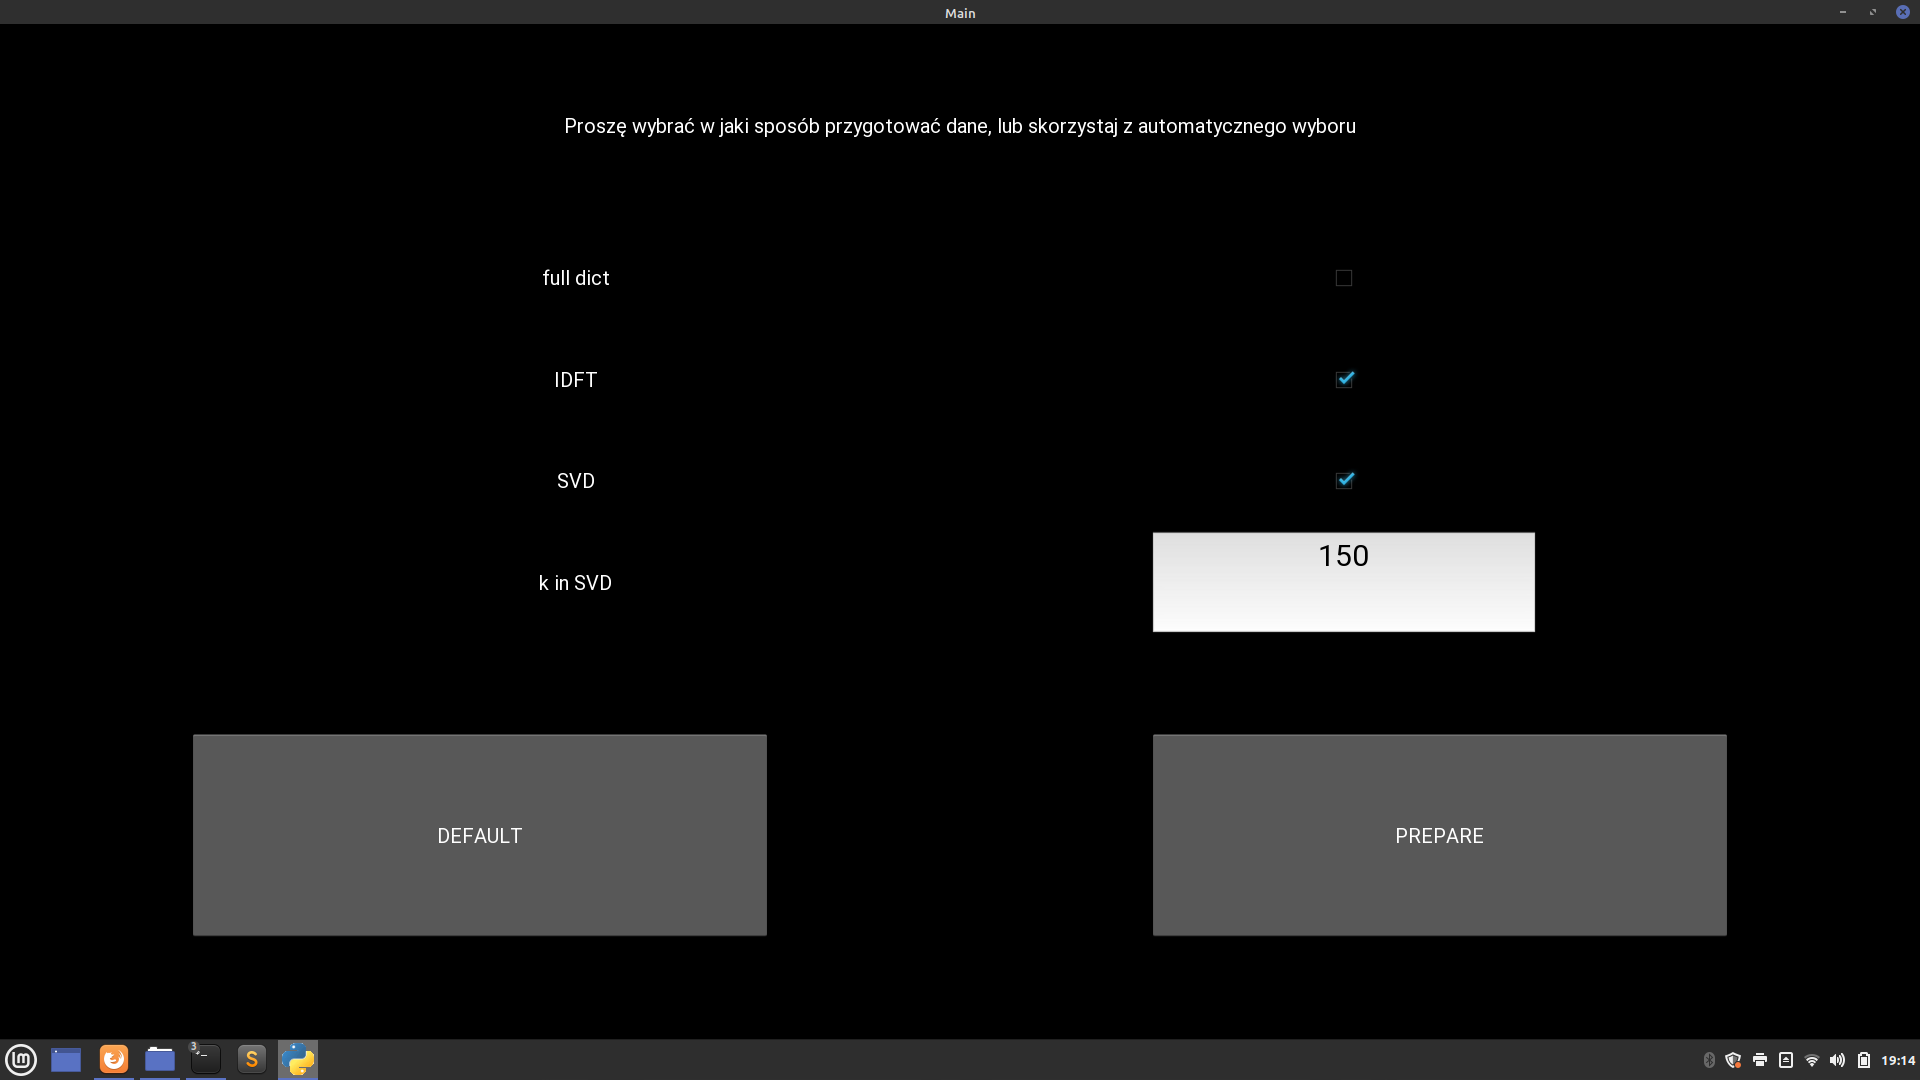

In [29]:
from IPython.display import Image
Image(filename='1.png')

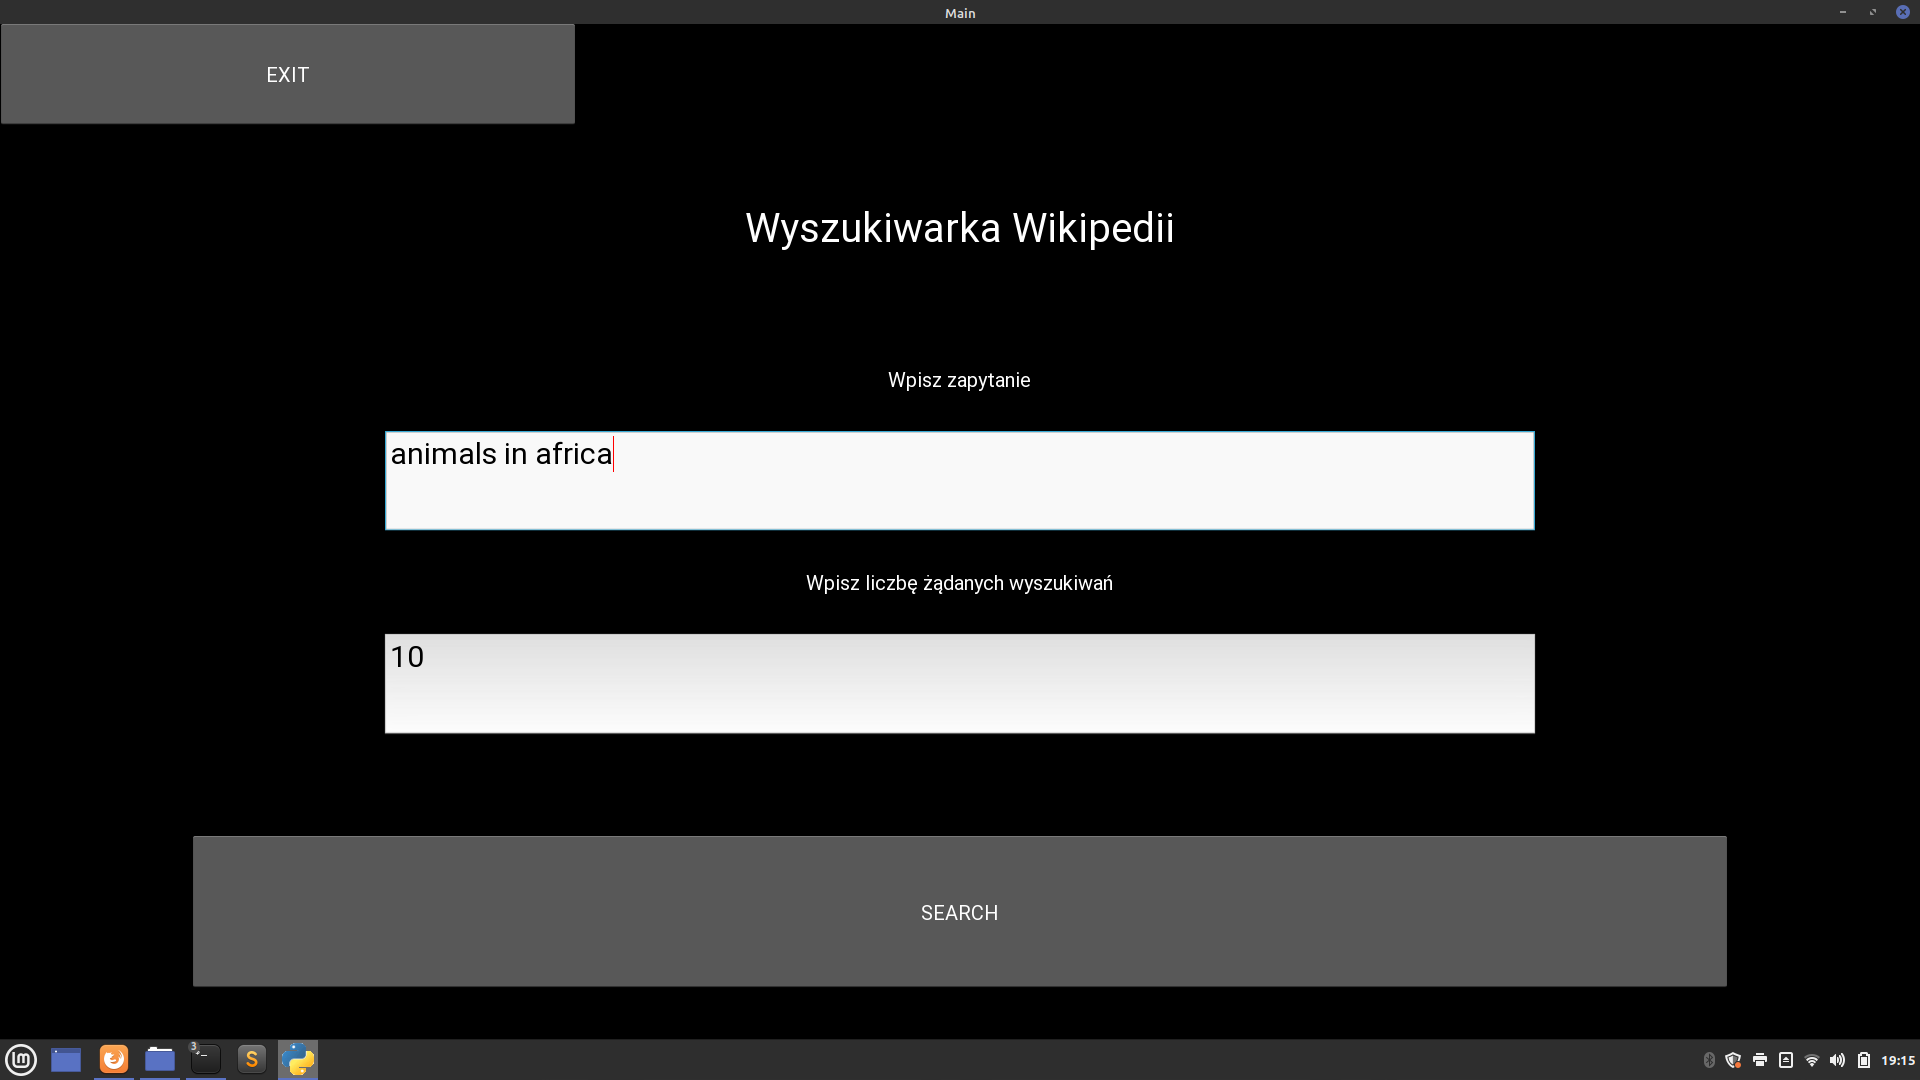

In [30]:
Image(filename='2.png')

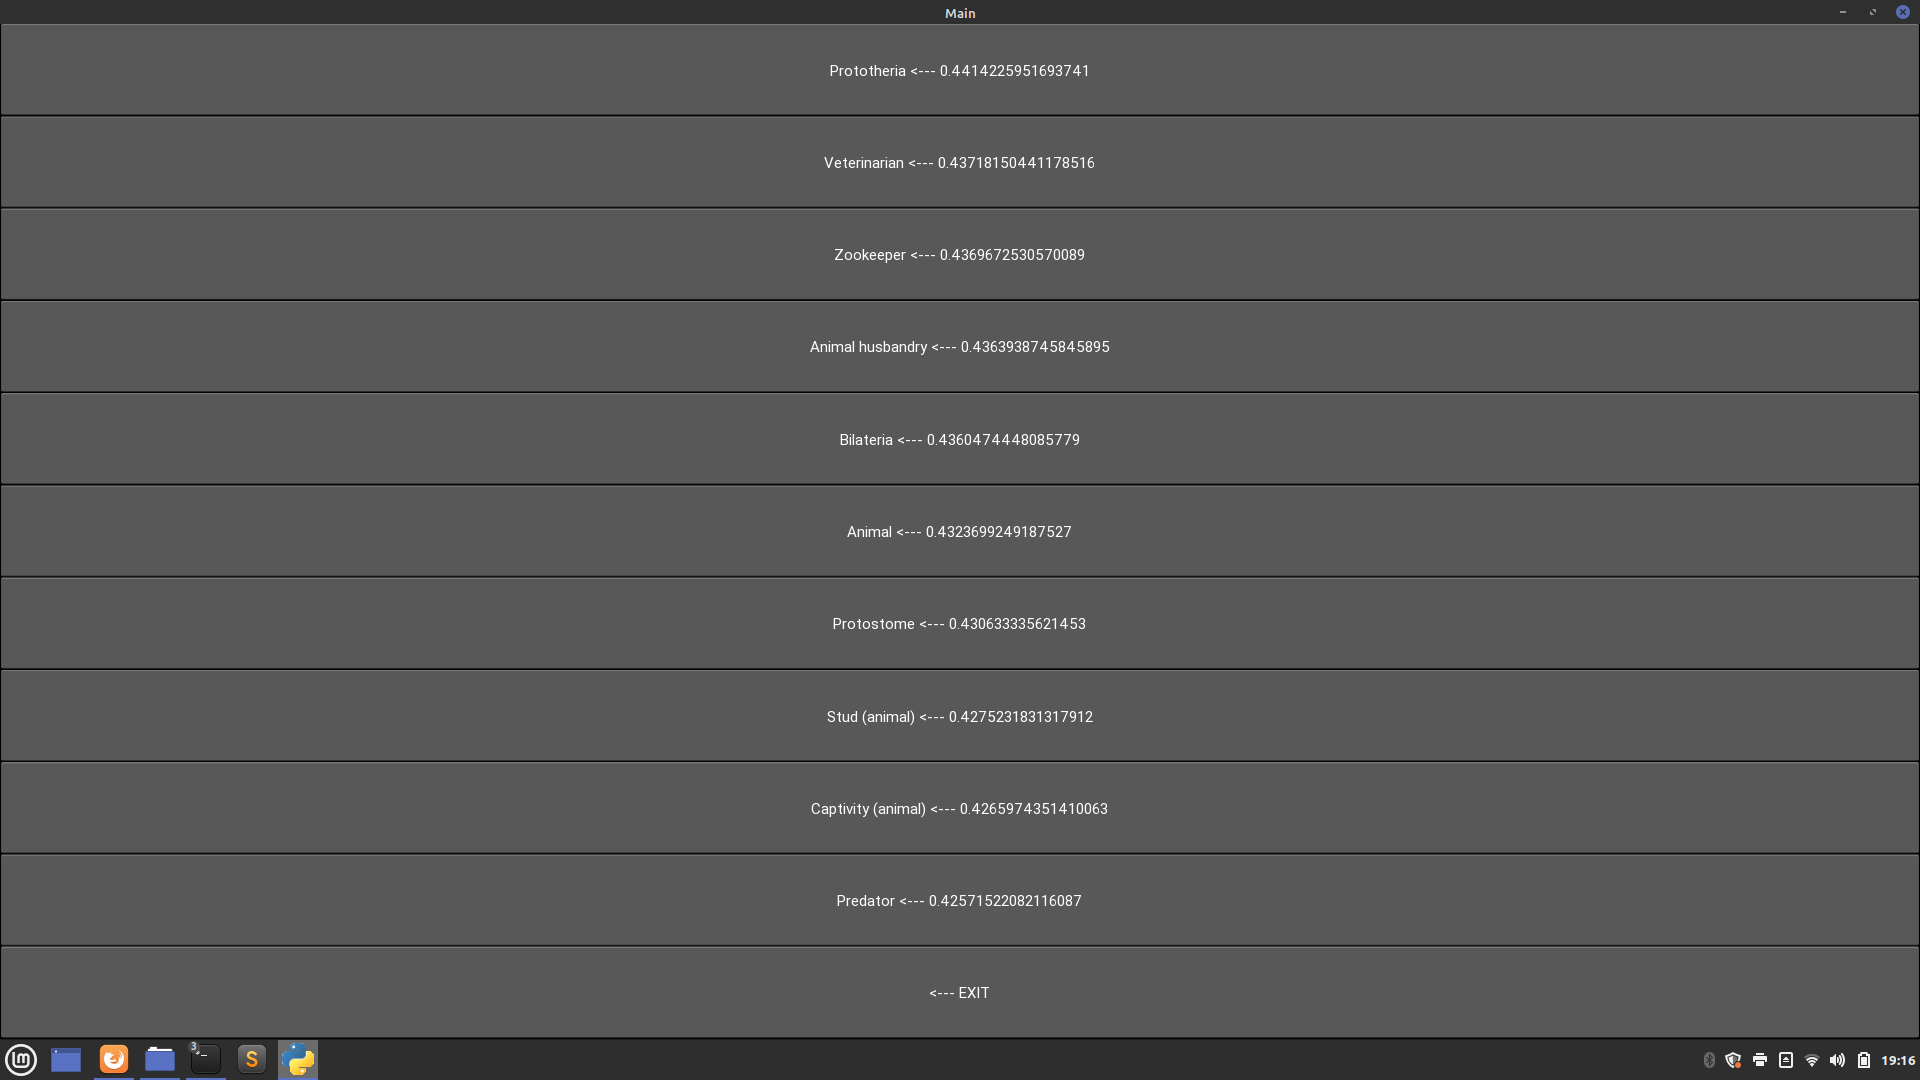

In [31]:
Image(filename='3.png')

In [32]:
read_wikipedia ()

In [33]:
swords = stopwords.words('english')
dictionary = dictionary_from_titles (swords)
save_dictionary (dictionary)
prepare_sites_raw(dictionary)

In [34]:
dictionary_full = make_dictionary (swords)
save_dictionary (dictionary_full, filepath='dict_full.txt')
prepare_sites_raw(dictionary_full, filepath="data_full.txt")

## Ciekawe zapytania i wyniki wyszukiwania

Poniżej przedstawiam kilka zapytań dla których znalazłem ciekawe rezultaty. Korzystam z IDF i SVD ze 130 wartościami własnymi. Zapytania charakteryzują się nie pytaniem wprost, lecz oczekując na rezultaty związane znaczeniowo z tymi słowami.

In [35]:
arr = reduce_noise (IDF_vectors, 120, len(dictionary))

In [36]:
k = 10
question = "sweet desert"
search (question, k, dictionary, arr, filepaths)

Ziziphus mauritiana <-- 0.04201761998928754
Cedrus deodara <-- 0.04108069521065928
Fig <-- 0.04047658584167956
Ziziphus <-- 0.04033118915520513
Cloudberry <-- 0.04030790702365676
Tundra <-- 0.04001132218236902
Passionfruit <-- 0.03997876781709279
Nelumbo <-- 0.03982158765856294
Jambul <-- 0.039761033450416906
Lily <-- 0.039413609882836986


In [37]:
k = 10
question = "pretty device"
search (question, k, dictionary, arr, filepaths)

Device <-- 0.0675502694910761
Mobile device <-- 0.06383558184609346
FireWire <-- 0.06278340352530024
Optical disc drive <-- 0.06251123258810404
Peripheral equipment <-- 0.06168119331487674
Telegram <-- 0.06082999006459618
USB hub <-- 0.06040723717688443
Tape drive <-- 0.06026445251124435
SIMATIC <-- 0.060202444272123505
USB flash drive <-- 0.0597380762233968


In [38]:
k = 10
question = "device to hearing sound"
search (question, k, dictionary, arr, filepaths)

Tube sound <-- 0.13875544648230473
Stereo <-- 0.130791825859955
Heartbeat <-- 0.1155646763251147
Sound <-- 0.11292552553698885
Sound card <-- 0.11190055906781521
Resonator <-- 0.11185876623532702
Vibrating string <-- 0.11157494559618283
Synthesizer <-- 0.11110477521155508
Loudspeaker <-- 0.11082400109541456
Empty string <-- 0.10886004185338781


In [39]:
k = 10
question = "the best athlete"
search (question, k, dictionary, arr, filepaths)

Halle Berry <-- 0.14321680797855624
Geoffrey Rush <-- 0.14316272418392975
Al Pacino <-- 0.1428055223830628
Helen Hunt <-- 0.13964543112590697
Laura Dern <-- 0.13935434126272284
Joanne Woodward <-- 0.13923925111846316
Adrien Brody <-- 0.1388190496448703
Luise Rainer <-- 0.13845622865574644
Candice Bergen <-- 0.13790145454714126
Cher <-- 0.1376418446990615


In [40]:
k = 10
question = "tired run"
search (question, k, dictionary, arr, filepaths)

Long distance race <-- 0.09374866138194504
Run (baseball) <-- 0.07955858846744056
Running <-- 0.07782977373627001
Earned run average <-- 0.07627218425013026
Southampton 45 <-- 0.07411411849786625
Drop shot <-- 0.07320585079405798
Xebian <-- 0.07293956229486263
M-Tram <-- 0.07260221109016715
Home run <-- 0.07182095696407712
Relay race <-- 0.0712128494230011


In [41]:
del(arr)

Podsumowując zadanie zauważam pewne usprawnienia, które można by poczynić. Zwiększenie pamięci RAM, a co za tym idzie zwiększenie słownika zncząco poprawiło by jakość wyszukiwań. Można by również skorzystać z webcrowlera aby stworzyć ciekawszą bazę stron.